In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

$\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

We wish to scan over:
1. Intensity
2. Detuning
    
    a. Trapping frequency

    b. B-field (strength)

    c. Laser frequency

## 1. Set up the trap

In [341]:
# Construct the system
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
ion1 = ca
ion2 = ca

⁴⁰Ca

In [342]:
chain = LinearChain(
        ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


LinearChain(2 ions)

In [343]:
#################### Chamber-independent laser properties ####################
timescale = 1e-6

DETUNING = 1e4 
GATE_TIME = 1/DETUNING # seconds

laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
# B-field polarized between x and z. That has something to do with our
# choice of polarization and wavevector, but not 100% sure of the relation
laser1.ϵ = x̂
laser1.k = ẑ

laser2.ϵ = x̂
laser2.k = ẑ

#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################
wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)
print("laser1.λ: ", laser1.λ)

vibrational_mode = modes(chamber)[1]
ν = frequency(vibrational_mode)

d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
Δ_blue = ν + DETUNING - d# <-- This is the "sideband detuning", which depends on the gate-time detuning but is not the same thing
Δ_red = -(ν + DETUNING - d)

laser1.Δ = Δ_blue # blue sideband
laser2.Δ = Δ_red; # red sideband


laser1.λ: 7.291469940286195e-7

## 2. Intensity scan

In [344]:
function get_bell_state_fidelity(state)
    rho = dm(state)
    rho_electronic = ptrace(rho, 3)
    fid = fidelity(rho_electronic, BELL_STATE_ELECTRONIC)
    return fid 
end

function get_entanglement_entropy(ρ)
    ρ_red = ptrace(ρ, 3)
    S = entropy_vn(ρ_red)
    return S
end

# Initial state
ψ0_electronic = ca["S"] ⊗ ca["S"]
ψ0_motional = vibrational_mode[0]
ψ0 = ψ0_electronic ⊗ ψ0_motional

# Bell state to which we compare
BELL_STATE_ELECTRONIC = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2);

In [345]:
# intensity_from_pitime to get rough estimate of the range over which to scan
η = abs(lambdicke(vibrational_mode, ca, laser1))
I_pitime = intensity_from_pitime(1, η / DETUNING , 1, ("S", "D"), chamber)
I_range = 0:I_pitime*1e-2:I_pitime*1.5

timescale = 1e-6
t_range = 0:GATE_TIME*1e-3:GATE_TIME

fidelities = zeros(length(I_range))
entanglement_entropies = zeros(length(I_range))
idx = Int(0)
for I in I_range
    idx += 1

    intensity!(laser1, I)
    intensity!(laser2, I)

    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end

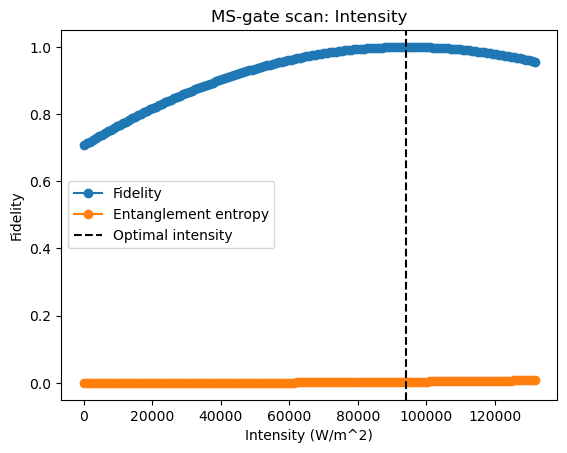

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s

Calibrated intensity = 93975.34935500399 W/m^2 
Max fidelity = 0.9997913846503805
Entanglement entropy at max fidelity = 0.0035837530041411933


In [346]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
I_optimal = I_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")

print("\nCalibrated intensity = ", I_optimal, " W/m^2 \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(I_range, fidelities, "o-", label = "Fidelity")
plt.plot(I_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=I_optimal, color="black", linestyle="--", label="Optimal intensity")
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: Intensity")
plt.legend()
plt.display(fig)
plt.close()

Plot %-change in intensity (wrt I_optimal) vs fidelity

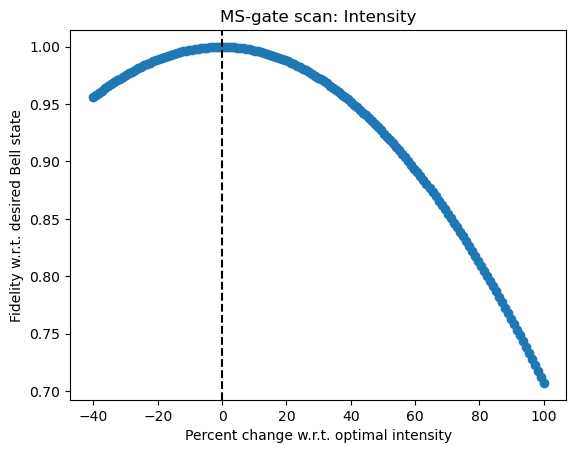

In [347]:
percent_change_intensity = 100 .*(I_optimal .- I_range)/I_optimal

fig = plt.figure()
plt.plot(percent_change_intensity, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent change w.r.t. optimal intensity")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: Intensity")
plt.display(fig)

Set the optimal intensity so we can start scanning the other parameters

In [350]:
INTENSITY = I_optimal
intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY)

#33 (generic function with 1 method)

Keeping track of global parameters:
- DETUNING (ideal)
- GATE_TIME
- INTENSITY

In [398]:
I_optimal

93975.34935500399

In [397]:
I_pitime

87827.42930374204

## 3. Detuning (actual): Trapping frequency

TODO: Include diagram from Sara meeting

Trap-frequency fluctuation $\Longleftrightarrow$ all reds spread (positive change) or squeeze (negative change)

In [364]:
ν_target = 2.5e5
ν_range = ν_target*1e-1:ν_target*1e-2:ν_target*2

fidelities = zeros(length(ν_range))
entanglement_entropies = zeros(length(ν_range))
idx = Int(0)
for ν_actual in ν_range
    idx += 1

    chain = LinearChain(
        ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6, z=ν_actual ), selectedmodes=(;z=[1],)
    )
    
    laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
    laser1.ϵ = x̂
    laser1.k = ẑ

    laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
    laser2.ϵ = x̂
    laser2.k = ẑ

    #################### Chamber ####################
    chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

    #################### Chamber-dependent laser properties ####################
    wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
    wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)

    d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
    Δ_blue = ν_target + DETUNING - d# <-- This is the "sideband detuning", which depends on the gate-time detuning but is not the same thing
    Δ_red = -(ν_target + DETUNING - d)

    laser1.Δ = Δ_blue # blue sideband
    laser2.Δ = Δ_red; # red sideband

    intensity!(laser1, I_optimal)
    intensity!(laser2, I_optimal)

    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end



┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonS

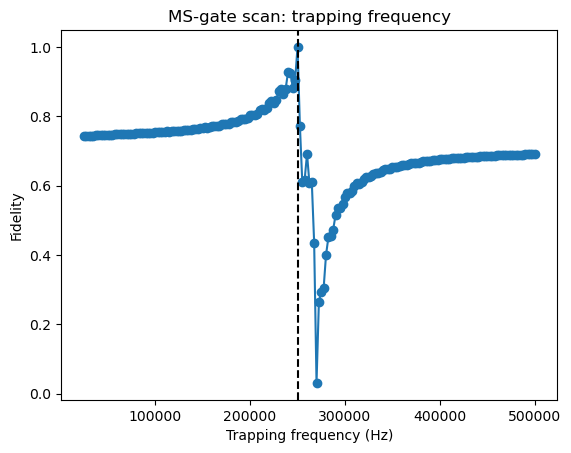

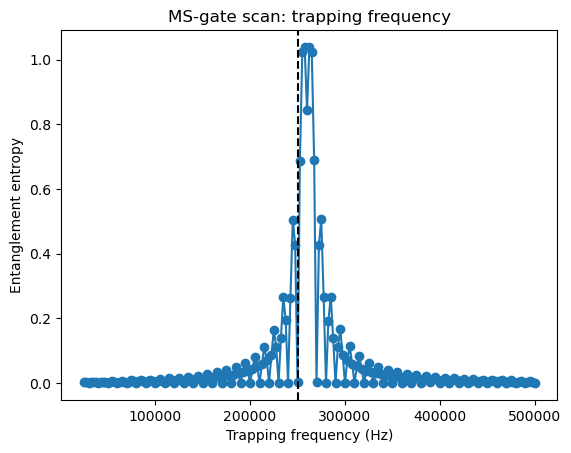

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Intensity = 93975.34935500399 W/m^2 

Calibrated trapping frequency = 250000.0 Hz 
Max fidelity = 0.9997913846503805
Entanglement entropy at max fidelity = 0.0035837530041411933


In [366]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
ν_optimal = ν_range[max_fidel_idx[1]]


print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("Intensity = ", INTENSITY, " W/m^2 \n")

print("\nCalibrated trapping frequency = ", ν_optimal, " Hz \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(ν_range, fidelities, "o-", label = "Fidelity")
plt.axvline(x=ν_optimal, color="black", linestyle="--", label="Optimal intensity")
plt.xlabel("Trapping frequency (Hz)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: trapping frequency")
plt.display(fig)
plt.close()

fig = plt.figure()
plt.plot(ν_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=ν_optimal, color="black", linestyle="--", label="Optimal intensity")
plt.xlabel("Trapping frequency (Hz)")
plt.ylabel("Entanglement entropy")
plt.title("MS-gate scan: trapping frequency")
plt.display(fig)
plt.close()


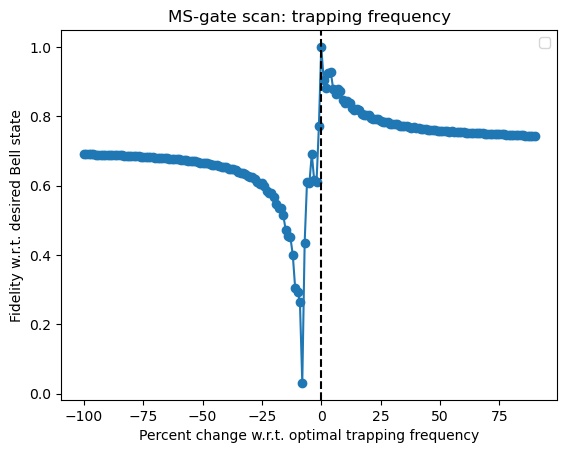

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [367]:
percent_change_tf = 100 .*(ν_optimal .- ν_range)/ν_optimal

fig = plt.figure()
plt.plot(percent_change_tf, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent change w.r.t. optimal trapping frequency")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: trapping frequency")
plt.legend()
plt.display(fig)

In [395]:
ν_optimal

250000.0

In [396]:
ν_target

250000.0

I suppose it makes sense that $\nu_{\text{optimal}} = \nu_{\text{mean}}$ - the intensity was calibrated for $\nu_{\text{mean}}$.

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


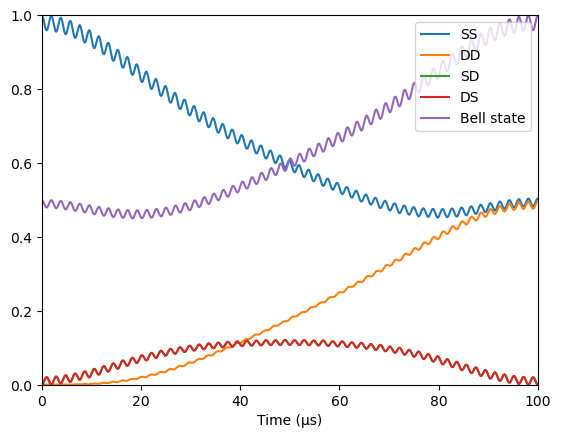

  0.099775 seconds (1.76 M allocations: 67.441 MiB, 5.61% gc time)
Bell-state fidelity: 0.9997913846503805
Electronic-Motional entanglement entropy: 0.0035837530041411933 + 0.0im


In [368]:
chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=ν_mean ), selectedmodes=(;z=[1],)
)

    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
laser1.ϵ = x̂
laser1.k = ẑ

laser2.ϵ = x̂
laser2.k = ẑ

#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################
wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)

d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
Δ_blue = ν_mean + DETUNING - d# <-- This is the "sideband detuning", which depends on the gate-time detuning but is not the same thing
Δ_red = -(ν_mean + DETUNING - d)

laser1.Δ = Δ_blue # blue sideband
laser2.Δ = Δ_red; # red sideband

intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY)
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);
# solve system
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

SS = ionprojector(chamber, "S", "S") 
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")


In [369]:
TRAPPING_FREQUENCY = ν_optimal

250000.0

Keeping track of global parameters:
- DETUNING (ideal)
- GATE_TIME
- INTENSITY
- TRAPPING_FREQUENCY

## 4. Detuning (actual)

Laser frequency fluctuation $\Longleftrightarrow$ all greens shift (same direction, same amount)

### 4.a. Determining reasonably-computable orders-of-magnitude for fluctuations in the laser wavelength

Computing the Hamiltonian for a given laser frequency shift to arbitray order is computationally intractable, so we have to choose:
1. An RWA cutoff
    a. We choose $\texttt{RWA\_CUTOFF = 1e20}$ somewhat arbitrarily
2. An absolute maximum fluctuation in the laser wavelength. We find $\delta \lambda\_\texttt{MAX}$ empirically (see cell $\texttt{4.a.i}$ below). 

Interestingly enough, we don't get the same result when varying the laser-detuning $\texttt{laser.}\Delta$ vs. the laser-wavelength $\texttt{laser.}\lambda$, i.e. choosing $\delta \lambda = c/\delta f$ or vice-versa (compare cells $\texttt{4.a.i}$ and $\texttt{4.a.ii}$ below). They're certainly different parameters in the IonSim master equation, but varying either one should correspond to the same (or at least similar) physical behavior (if my understanding of the $\texttt{laser.}\lambda$ and $\texttt{laser.}\Delta$ parameters is correct)

$\textbf{TODO:}$ Figure out why this is.

4.a.i. Varying wavelength $\texttt{laser.}\lambda$

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


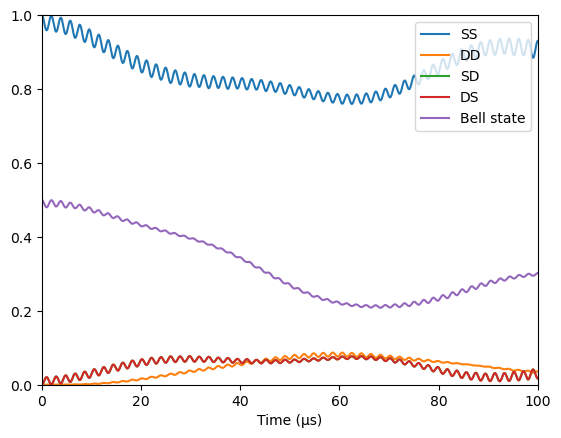

  0.131209 seconds (1.74 M allocations: 66.441 MiB, 10.73% gc time)
Bell-state fidelity: 0.5499414657427376
Electronic-Motional entanglement entropy: 0.1543687021453811 + 0.0im


1.0e-15

In [370]:
RWA_CUTOFF = 1e20

chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
laser1.ϵ = x̂
laser1.k = ẑ

laser2.ϵ = x̂
laser2.k = ẑ

intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY);

######################################## Detuning/Wavelength stuff ########################################

λ_target = transitionwavelength(ca, ("S", "D"), chamber)

Δ_blue = TRAPPING_FREQUENCY + DETUNING - d 
Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d )

laser1.Δ = Δ_blue # blue sideband
laser2.Δ = Δ_red; # red sideband


#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################

# Setting δλ directly
δλ = -1e-17 # \pm 1e-15 is the LARGEST order-of-magnitude that terminates reasonably and doesn't give a trivial result (i.e. just straight horizontal lines)
wavelength!(laser1, λ_target + δλ)
wavelength!(laser2, λ_target + δλ)

# # Setting δλ as a fraction of λ_target
# δλ = λ_target*1e-9 # \pm λ_target*1e-9 is the LARGEST OOM that terminates reasonably and doesn't give a trivial result
# wavelength!(laser1, λ_target - δλ)
# wavelength!(laser2, λ_target - δλ)

# # Setting δf as a fraction of f_target, then δλ = c0/δf
# c0 = 2.99792458e8
# f_target = c0/λ_target
# δf = f_target*1e9 # 1e9 is the SMALLEST OOM that terminates reasonably and doesn't give a trivial result
# δλ = -c0/δf
# wavelength!(laser1, λ_target + δλ)
# wavelength!(laser2, λ_target + δλ)

# # No fluctuation
# wavelength!(laser1, λ_target)
# wavelength!(laser2, λ_target)

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")

δλ_MAX = 1e-15


4.a.ii. Varying detuning $\texttt{laser.}\Delta$

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


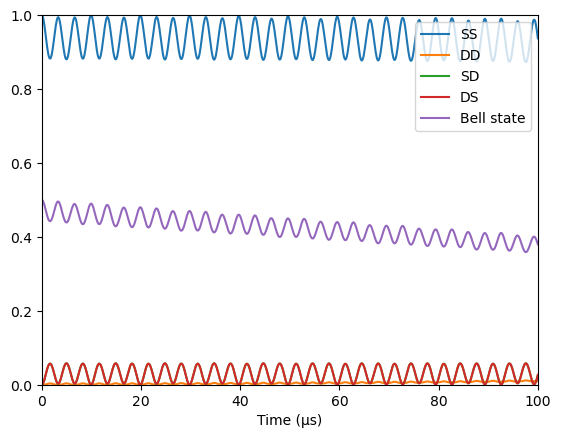

  0.092124 seconds (1.59 M allocations: 61.043 MiB, 7.75% gc time)
Bell-state fidelity: 0.6166353354899833
Electronic-Motional entanglement entropy: 0.004005969531643849 + 0.0im


In [371]:
chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
laser1.ϵ = x̂
laser1.k = ẑ

laser2.ϵ = x̂
laser2.k = ẑ

intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY);

######################################## Detuning/Wavelength stuff ########################################

λ_target = transitionwavelength(ca, ("S", "D"), chamber)

# Setting δf directly
# δf = 1e5 # \pm 1e5 is the LARGEST OOM that terminates reasonably and doesn't give a trivial result. Corresponds to δλ=c0/δf \sim 3e3  
# d = 0
# Δ_blue = TRAPPING_FREQUENCY + DETUNING - d + δf 
# Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d + δf)

# Setting δf as a fraction of f_target
# c0 = 2.99792458e8
# f_target = c0/λ_target
# δf = -f_target*1e-9 # 1e-9 is the LARGEST oom that terminates reasonably and doesn't give a trivial result
# d = 0
# Δ_blue = TRAPPING_FREQUENCY + DETUNING - d + δf 
# Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d + δf)


# Setting δλ as a fraction of λ_target, then δf = c0/δλ
c0 = 2.99792458e8
δλ = λ_target*1e9 # \pm λ_target*1e9 is the SMALLEST OOM that terminates reasonably and doesn't give a trivial result
δf = -c0/δλ
d = 0
Δ_blue = TRAPPING_FREQUENCY + DETUNING - d + δf 
Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d + δf)

# No fluctuation
# d = 0
# Δ_blue = TRAPPING_FREQUENCY + DETUNING - d 
# Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d )


laser1.Δ = Δ_blue # blue sideband
laser2.Δ = Δ_red; # red sideband


#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################

wavelength!(laser1, λ_target)
wavelength!(laser2, λ_target)

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")

## 4.b Running laser-wavelength scan

In [372]:
λ_target = transitionwavelength(ca, ("S", "D"), chamber)
δλ_MAX = 1e-15
δλ_power_range = -25:0.1:-15
δλ_range = 10 .^ δλ_power_range
λ_plus_range = λ_target .+ δλ_range
λ_minus_range = λ_target .- δλ_range
λ_range = vcat(λ_minus_range, λ_plus_range)
length(λ_range)

202

In [373]:
λ_target = transitionwavelength(ca, ("S", "D"), chamber)
δλ_MAX = 1e-15
δλ_power_range = -25:0.1:-15
δλ_range = 10 .^ δλ_power_range
λ_plus_range = λ_target .+ δλ_range
λ_minus_range = λ_target .- δλ_range
λ_range = vcat(λ_minus_range, λ_plus_range)

fidelities = zeros(length(λ_range))
entanglement_entropies = zeros(length(λ_range))
idx = Int(0)
for λ_actual in λ_range
    idx += 1

    #################### Chamber ####################
    chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

    #################### Chamber-dependent laser properties ####################

    d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
    Δ_blue = TRAPPING_FREQUENCY + DETUNING - d 
    Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d)

    laser1.Δ = Δ_blue # blue sideband
    laser2.Δ = Δ_red; # red sideband

    intensity!(laser1, INTENSITY)
    intensity!(laser2, INTENSITY)

    wavelength!(laser1, λ_actual)
    wavelength!(laser2, λ_actual)

    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end



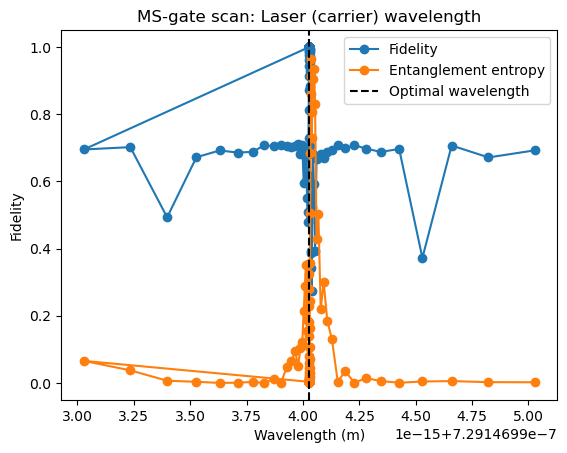

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s

Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 

Calibrated wavelength= 7.291469940286511e-7 W/m^2 
Max fidelity = 0.9998161509453058
Entanglement entropy at max fidelity = 0.002903568196670668


In [378]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
λ_optimal = λ_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("\nIntensity = ", INTENSITY, " W/m^2 \n")
print("Trapping frequency = ", TRAPPING_FREQUENCY, " Hz \n")

print("\nCalibrated wavelength= ", λ_optimal, " W/m^2 \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(λ_range, fidelities, "o-", label = "Fidelity")
plt.plot(λ_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=λ_optimal, color="black", linestyle="--", label="Optimal wavelength")
plt.xlabel("Wavelength (m)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.legend()
plt.display(fig)
plt.close()

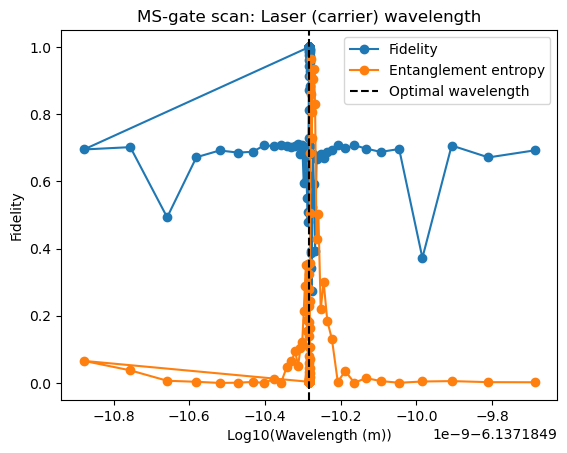

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s

Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 

Calibrated wavelength= 7.291469940286511e-7 W/m^2 
Max fidelity = 0.9998161509453058
Entanglement entropy at max fidelity = 0.002903568196670668


In [386]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
λ_optimal = λ_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("\nIntensity = ", INTENSITY, " W/m^2 \n")
print("Trapping frequency = ", TRAPPING_FREQUENCY, " Hz \n")

print("\nCalibrated wavelength= ", λ_optimal, " m \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(broadcast(log10, λ_range), fidelities, "o-", label = "Fidelity")
plt.plot(broadcast(log10, λ_range), entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=log10(λ_optimal), color="black", linestyle="--", label="Optimal wavelength")
plt.xlabel("Log10(Wavelength (m))")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.legend()
plt.display(fig)
plt.close()

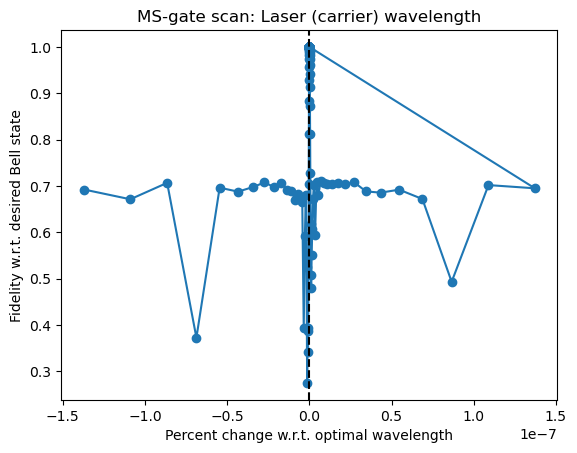

In [375]:
percent_change_wavelength = 100 .*(λ_optimal .- λ_range)/λ_optimal

fig = plt.figure()
plt.plot(percent_change_wavelength, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent change w.r.t. optimal wavelength")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.display(fig)

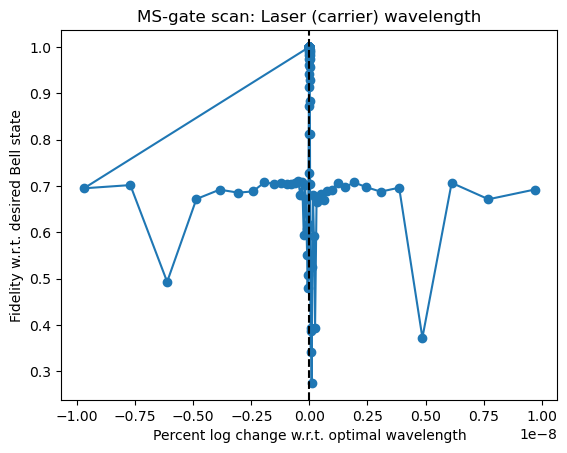

In [389]:
log_λ_range = broadcast(log10, λ_range)
percent_change_log_wavelength = 100 .*(log10(λ_optimal) .- log_λ_range)/log10(λ_optimal)

fig = plt.figure()
plt.plot(percent_change_log_wavelength, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent log change w.r.t. optimal wavelength")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.display(fig)

Keeping track of global parameters:
- DETUNING (ideal)
- GATE_TIME
- INTENSITY
- TRAPPING_FREQUENCY
- LASER_WAVELENGTH

In [390]:
LASER_WAVELENGTH = λ_optimal

7.291469940286511e-7

In [391]:
λ_optimal

7.291469940286511e-7

In [392]:
λ_target

7.291469940286195e-7

## 5. Finally, scan the magnetic field strength

In [425]:
chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser1.ϵ = x̂
laser1.k = ẑ
intensity!(laser1, INTENSITY)
wavelength!(laser1, LASER_WAVELENGTH)

laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
laser2.ϵ = x̂
laser2.k = ẑ
intensity!(laser2, INTENSITY)
wavelength!(laser2, LASER_WAVELENGTH)

d = 0
Δ_blue = TRAPPING_FREQUENCY + DETUNING - d 
Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d )
laser1.Δ = Δ_blue # blue sideband
laser2.Δ = Δ_red; # red sideband

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


In the future: fast fluctuations and polarization direction?

TODO: Setting $\texttt{chamber.B = B + } \delta \texttt{B}$ gives similar, but not exactly the same, result as setting $\texttt{chamber.}\delta\texttt{B = }\delta\texttt{B}$.

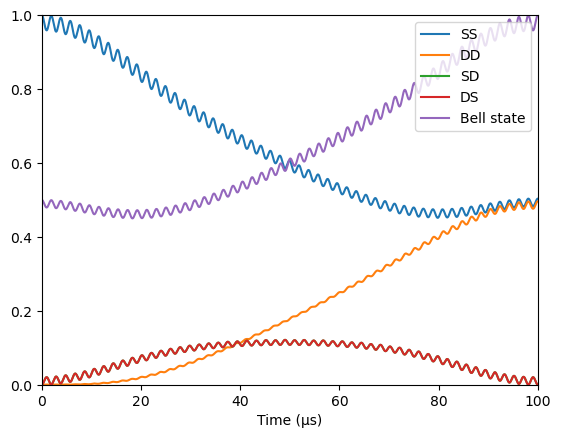

  0.106633 seconds (1.76 M allocations: 67.441 MiB, 9.15% gc time)
Bell-state fidelity: 0.9998161509453058
Electronic-Motional entanglement entropy: 0.002903568196670668 + 0.0im


In [426]:
δB = 0# 1e-7 # Pretty much as large as idx can go before the simulation becomes too slow

chamber = Chamber(iontrap=chain, B=6e-4 + δB, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")

In [427]:
B_target = 6e-4
δB_MAX = 1e-4
δB_power_range = -10:0.1:-4
δB_range = 10 .^ δB_power_range
B_plus_range = B_target .+ δB_range
B_minus_range = B_target .- δB_range
B_range = vcat(B_minus_range, B_plus_range)
δB_range = B_target .- B_range

fidelities = zeros(length(B_range))
entanglement_entropies = zeros(length(B_range))
idx = Int(0)
for B_actual in B_range
    idx += 1

    #################### Chamber ####################
    chamber = Chamber(iontrap=chain, B=B_actual, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end

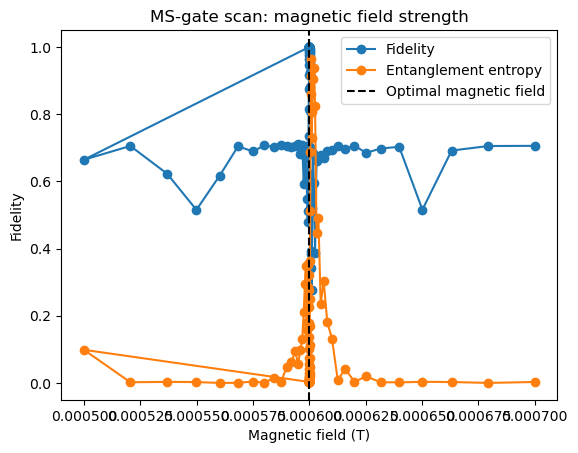

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 
Laser (carrier) wavelength= 7.291469940286511e-7 m 

Calibrated magnetic field= 0.0005999998999999999 T 
Max fidelity = 0.9998161808711384
Entanglement entropy at max fidelity = 0.0029198516661979408


In [428]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
δB_optimal = δB_range[max_fidel_idx[1]]
B_optimal = B_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("Intensity = ", INTENSITY, " W/m^2 \n")
print("Trapping frequency = ", TRAPPING_FREQUENCY, " Hz \n")
print("Laser (carrier) wavelength= ", LASER_WAVELENGTH, " m \n")

print("\nCalibrated magnetic field= ", B_optimal, " T \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(B_range, fidelities, "o-", label = "Fidelity")
plt.plot(B_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=B_optimal, color="black", linestyle="--", label="Optimal magnetic field")
plt.xlabel("Magnetic field (T)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: magnetic field strength")
plt.legend()
plt.display(fig)
plt.close()

In [423]:
B_target

0.0006

In [424]:
B_optimal

0.0005999998999999999

In [430]:
B_STRENGTH = B_optimal

0.0005999998999999999

## 6. Get final fidelity

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


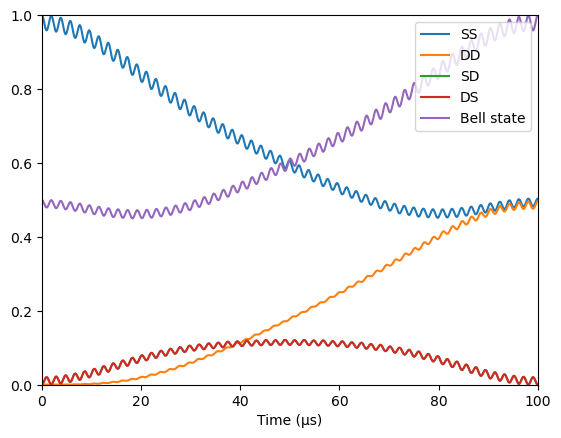

  0.139673 seconds (1.76 M allocations: 67.441 MiB, 9.65% gc time)
Bell-state fidelity: 0.9998161808711384 - 1.462547235324849e-9im
Electronic-Motional entanglement entropy: 0.0029198516661979408 + 0.0im


In [436]:
#################### Ion-chain ####################

chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
#################### Lasers ####################

laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser1.ϵ = x̂
laser1.k = ẑ
intensity!(laser1, INTENSITY)
wavelength!(laser1, LASER_WAVELENGTH)

laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
laser2.ϵ = x̂
laser2.k = ẑ
intensity!(laser2, INTENSITY)
wavelength!(laser2, LASER_WAVELENGTH)

d = 0
Δ_blue = TRAPPING_FREQUENCY + DETUNING - d 
Δ_red = -(TRAPPING_FREQUENCY + DETUNING - d )
laser1.Δ = Δ_blue # blue sideband
laser2.Δ = Δ_red; # red sideband

#################### Chamber ####################

chamber = Chamber(iontrap=chain, B=B_STRENGTH, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

#################### Hamiltonian, simulation ####################

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, ψ0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ⊗ ca["S"] + 1im * ca["D"] ⊗ ca["D"])/√2) ⊗ one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # 𝔼(|S⟩|S⟩)
prob_DD = expect(DD, sol)  # 𝔼(|D⟩|D⟩)
prob_SD = expect(SD, sol)  # 𝔼(|S⟩|D⟩)
prob_DS = expect(DS, sol)  # 𝔼(|D⟩|S⟩)
prob_bell = expect(bell_state, sol)  # 𝔼((|S⟩|S⟩ + i|D⟩|D⟩)/√2)

# plot results
bs_fid = get_bell_state_fidelity(sol[end])
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)



print("Bell-state fidelity: ", bs_fid, "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")